https://colab.research.google.com/drive/1aun0OjBp90Ra2SizwvO6dLTFG65N5LSe?usp=sharing

# Understanding Pay Gaps Across Gender: Analysis of Income Over Two Decades

Group 7 Members: Yuchen Li, Tiancheng Yang, Yiming Wang, Qianyi Mo


#I. Introduction
In contemporary society, the ongoing debate about whether gender-based pay disparities exist remains a significant topic of discussion. This debate is often nuanced by various factors such as age groups, education levels, occupations, and years of experience. A critical question arises: Do substantial differences in pay exist between genders when other factors are held constant? Moreover, are these disparities more pronounced in certain demographic groups than in others? To address these inquiries, our study delved into income data alongside associated demographic factors, through fitting regression models on the data, ultimately making predicts on an individual's income based on variables like age, gender, race, education, and geographic location.

#II. Data Source
The dataset is the Panel Study of Income Dynamics (PSID) microdata over the 1980-2010 period, accessible from this link: https://www.kaggle.com/fedesoriano/gender-pay-gap-dataset.
The Panel Study of Income Dynamics (PSID) is a long-running and nationally representative survey initiated in 1968 at the University of Michigan. It collects data on income, employment, family structure, and other socio-economic factors from a diverse group of American households over an extended period.


#III. Data Preperation

In [ ]:
#Import necessary libraries(data manipulation and analysis; numerical operations; creating visualizations and etc.)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, SelectFromModel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from scipy.stats import randint as sp_randint
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
#import the module to mount drive and access file, after then read the file into dataframe
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PanelStudyIncomeDynamics.csv')

Mounted at /content/drive


In [ ]:
#display the head of the file to overview the columns' name
df.head()

,intnum68,pernum68,wave,sex,intnum,farminc,region,famwgt,relhead,age,...,foodcare,building,sales,officeadmin,farmer,constructextractinstall,production,transport,sumocc,LEHS
0,1152,24,1981,1,3505,0.0,1.0,17.000,10,34,...,0,0,1,0,0,0,0,0,1,0
1,5057,171,1981,1,675,0.0,2.0,2.000,10,32,...,0,0,0,0,0,0,1,0,1,1
2,6375,170,2009,1,8505,0.0,1.0,6.565,10,64,...,0,0,0,0,0,0,1,0,1,1
3,2261,3,1999,1,4202,0.0,2.0,25.973,10,50,...,0,0,0,0,0,0,0,1,1,1
4,5927,7,1990,1,605,0.0,3.0,14.819,10,26,...,0,0,0,0,0,0,1,0,1,1


In [ ]:
#using this column to drop some columns with specific form
columns_to_drop = [col for col in df.columns if col.startswith('orig') or col.startswith('predict') or (col.startswith('yrs') and col != 'yrsexp')]

df = df.drop(columns=columns_to_drop)

#define the column of income based on the overview of the head of the file.
income_col = ['farminc', 'annlabinc', 'labincbus']
df['total_income'] = df[income_col].sum(axis=1)

In [ ]:
# drop unnecessary columns, such as the same value for every one (i.e. military & employed, 1 for every one) and replicated information.
df = df.drop(columns=['ind', 'occ', 'occ2', 'ind2', 'occ2name', 'military', 'basesamp', 'sumocc', 'sumind', 'potexp2', 'lnrealwg', 'immigrantsamp','female', 'expendbase10','employed','wagesamp','potexp'])

 The dataset comprises various socio-economic attributes of individuals, including interview numbers, demographic information, employment details, and income-related variables.

After initial observation, we decided to continue with selected vital columns. Key columns include interview numbers, demographic information, employment details, income-related variables, and dummy variables indicating race, gender, and education status. The target variable is the wage variable, and we removed all irrelevant columns from the dataset.

We mapped the categorical columns based on the information in each column listed below.

In [ ]:
  # Map race names to codes, since there are different columns contain races
race_mapping = {
      'white': 1,
      'black': 2,
      'hisp': 3,
      'othrace': 4
}

df['Race'] = df[list(race_mapping.keys())].idxmax(axis=1)
df['Race'] = df['Race'].map(race_mapping)
df = df.drop(columns=list(race_mapping.keys()))

In [ ]:
#same situation as race_mapping, using mapping to corresponding industries.
industry_mapping = {
    'Agriculture': 'Agriculture',
    'miningconstruction': 'Mining and Construction',
    'durables': 'Durables Manufacturing',
    'nondurables': 'Non-durables Manufacturing',
    'Transport': 'Transport',
    'Utilities': 'Utilities',
    'Communications': 'Communications',
    'retailtrade': 'Retail Trade',
    'wholesaletrade': 'Wholesale Trade',
    'finance': 'Finance',
    'SocArtOther': 'Social Work, Arts, Recreation, Other Services',
    'hotelsrestaurants': 'Hotels and Restaurants',
    'Medical': 'Medical',
    'Education': 'Education',
    'professional': 'Professional Services',
    'publicadmin': 'Public Administration'
}

df['Industry'] = df[list(industry_mapping.keys())].idxmax(axis=1)

df['Industry'] = df['Industry'].map(industry_mapping)

#drop the original industry colunms for further coding.
df = df.drop(columns=list(industry_mapping.keys()))

In [ ]:
#using mapping to corresponding occupations
occupation_mapping = {
    'manager': 'Manager',
    'business': 'Business Operations Specialists',
    'financialop': 'Financial Operations Specialists',
    'computer': 'Computer and Math Technicians',
    'architect': 'Architects and Engineers',
    'scientist': 'Life, Physical and Social Sciences',
    'socialworker': 'Community and Social Workers',
    'postseceduc': 'Post-secondary Educators',
    'legaleduc': 'Other Education, Training, Library and Legal Occupations',
    'artist': 'Arts, Design, Entertainment, Sports and Media',
    'lawyerphysician': 'Physicians and Dentists',
    'healthcare': 'Nurses and HealthCare Practitioners and Technicians',
    'healthsupport': 'Healthcare Support Occupations',
    'protective': 'Protective Service Occupations',
    'foodcare': 'Food Preparation and Serving and Personal Care Services',
    'building': 'Building and Grounds Cleaning and Maintenance',
    'sales': 'Sales and Related',
    'officeadmin': 'Office and Administrative Support',
    'farmer': 'Farmer',
    'constructextractinstall': 'Construction, Extraction, Installation',
    'production': 'Production',
    'transport': 'Transportation and Materials Moving'
}

df['Occupation'] = df[list(occupation_mapping.keys())].idxmax(axis=1)

df['Occupation'] = df['Occupation'].map(occupation_mapping)

#drop the original occupation columns.
df = df.drop(columns=list(occupation_mapping.keys()))


In [ ]:
#degree mapping
degree_mapping = {
    0: 'No college degree',
    1: 'Bachelor’s w/o advanced degree',
    2: 'Advanced degree'
}

df['degree'] = df['degree'].map(degree_mapping)

In [ ]:
#rename the column with full name instead.
df = df.rename(columns={'degupd': 'degree_updated'})

df['degree_updated'] = df['degree_updated'].map(degree_mapping)

In [ ]:
#relhead_mapping
relhead_mapping = {
    10: 'head',
    20: 'legally married wife',
    22: 'cohabiting partner'
}

df['relhead'] = df['relhead'].map(relhead_mapping)

In [ ]:
#conditions_mapping
conditions = [
    df['northeast'] == 1,
    df['northcentral'] == 1,
    df['south'] == 1,
    df['west'] == 1
]

region_labels = ['North-East', 'North-Central', 'South', 'West, Alaska and Hawaii']


df['region'] = np.select(conditions, region_labels, default='Unknown')

df = df.drop(columns=['northeast', 'northcentral', 'south', 'west'])

In [ ]:
#rename columns to let audiences have better understanding
df = df.rename(columns={'schupd': 'sch_updated', 'unjob': 'union_covered','ft': 'full_time','wtrgov': 'work_in_gov'})

In [ ]:
#display the dataframe hence can find out the dtype of each column and null value(NaN) for further data cleaning.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33398 entries, 0 to 33397
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   intnum68        33398 non-null  int64  
 1   pernum68        33398 non-null  int64  
 2   wave            33398 non-null  int64  
 3   sex             33398 non-null  int64  
 4   intnum          33398 non-null  int64  
 5   farminc         33398 non-null  float64
 6   region          33398 non-null  object 
 7   famwgt          33398 non-null  float64
 8   relhead         33398 non-null  object 
 9   age             33398 non-null  int64  
 10  sch             33373 non-null  float64
 11  annhrs          33398 non-null  int64  
 12  annlabinc       33398 non-null  float64
 13  degree          33358 non-null  object 
 14  degree_updated  33358 non-null  object 
 15  sch_updated     33398 non-null  int64  
 16  annwks          33398 non-null  float64
 17  union_covered   33398 non-null 

##Data Dictionary

**Dataset Overview**

| Index | Feature           | Description |
|:------|:------------------|:------------|
| 1 | intnum68 | 1968 Interview Number |
| 2 | pernum68 | Person Number 68 |
| 3 | wave | Current Wave of the PSID |
| 4 | sex | Gender of Individual (1=male, 2=female) |
| 5 | intnum | Wave-specific Interview Number |
| 6 | farminc | Farm Income |
| 7 | region | Region of Current Interview |
| 8 | famwgt | PSID’s Family Weight, Used in Analyses |
| 9 | relhead | Relation to Head of Household (10=head; 20=married wife; 22=partner) |
| 10 | age | Age |
| 11 | sch | Highest Year of Schooling |
| 12 | annhrs | Annual Hours Worked |
| 13 | annlabinc | Annual Labor Income |
| 14 | degree | Agent's Degree Status (0=no degree; 1=bachelor’s; 2=advanced) |
| 15 | degupd | Agent's Degree Status (Updated with 2009 Values) |
| 16 | schupd | Updated Years of Schooling |
| 17 | annwks | Annual Weeks Worked |
| 18 | union_covered | Union Coverage Indicator |
| 19 | usualhrwk | Usual Hours Worked Per Week |
| 20 | labincbus | Labor Income from Business |
| 21 | yrsexp | Experience |
| 22 | selfemp | Self Employed Status (1=Self Employed) |
| 23 | smsa | SMSA Dummy Variable |
| 24 | perconexp | Personal Consumption of Previous Year |
| 25 | hrwage | Hourly Wage |
| 26 | annhrs2 | Alternate Measure of Annual Hours Worked |
| 27 | inflate | Inflation Factor for Earnings Conversion |
| 28 | realhrwage | Real Hourly Wage in 2010 Dollars |
| 29 | ft | Full-Time Work Status Indicator |
| 30 | ba | Bachelor's Degree Indicator |
| 31 | adv | Advanced Degree Indicator |
| 32 | LEHS | High School or Less Education Indicator |
| 33 | total_income | Total Income |
| 34 | Race | Race Identifier |
| 35 | Industry | Industry of Employment |
| 36 | Occupation | Occupation Type |

In [ ]:
#display the descriptive statistics for numerical columns
df.describe()

,intnum68,pernum68,wave,sex,intnum,farminc,famwgt,age,sch,annhrs,...,hrwage,annhrs2,inflate,realhrwage,full_time,ba,adv,LEHS,total_income,Race
count,33398.000000,33398.000000,33398.000000,33398.000000,33398.000000,33398.000000,33398.000000,33398.000000,33373.000000,33398.000000,...,33398.000000,33303.000000,33398.000000,33398.000000,33398.000000,33398.000000,33398.000000,33398.000000,3.339800e+04,33398.000000
mean,2942.203964,75.144260,2000.293221,1.513863,3935.475058,104.879544,18.593345,40.467872,13.567375,1990.103449,...,18.418722,1918.254890,1.337749,22.102140,0.868884,0.192227,0.092670,0.715103,3.735983e+04,1.412600
std,2198.106202,81.071224,10.536950,0.499815,2267.144304,2662.001098,14.428494,10.401476,2.403400,623.592732,...,19.462814,589.727567,0.437902,20.508869,0.337532,0.394056,0.289974,0.451372,4.167138e+04,0.614679
min,4.000000,1.000000,1981.000000,1.000000,1.000000,-5000.000000,0.000000,25.000000,0.000000,10.000000,...,0.891473,0.000000,1.000000,2.016176,0.000000,0.000000,0.000000,0.000000,3.000000e+01,1.000000
25%,1152.000000,4.000000,1990.000000,1.000000,2034.000000,0.000000,5.209500,31.000000,12.000000,1767.000000,...,8.823529,1720.000000,1.015900,12.055494,1.000000,0.000000,0.000000,0.000000,1.600000e+04,1.000000
50%,2210.000000,30.000000,2007.000000,2.000000,3854.500000,0.000000,17.184999,39.000000,13.000000,2000.000000,...,14.423077,1960.000000,1.073115,18.054652,1.000000,0.000000,0.000000,1.000000,2.900000e+04,1.000000
75%,5464.000000,172.000000,2009.000000,2.000000,5732.750000,0.000000,27.212249,49.000000,16.000000,2277.000000,...,22.373541,2158.800049,1.572618,26.472507,1.000000,0.000000,0.000000,1.000000,4.600000e+04,2.000000
max,6872.000000,262.000000,2011.000000,2.000000,8940.000000,200000.000000,167.679001,64.000000,18.000000,5840.000000,...,1000.000000,5600.000000,2.311526,1000.000000,1.000000,1.000000,1.000000,1.000000,1.500000e+06,4.000000


In [ ]:
#display the new dataframe to check status
df.head()

,intnum68,pernum68,wave,sex,intnum,farminc,region,famwgt,relhead,age,...,inflate,realhrwage,full_time,ba,adv,LEHS,total_income,Race,Industry,Occupation
0,1152,24,1981,1,3505,0.0,North-East,17.000,head,34,...,2.311526,14.447040,1,1,0,0,10000.0,1,Finance,Sales and Related
1,5057,171,1981,1,675,0.0,North-Central,2.000,head,32,...,2.311526,40.429485,1,0,0,1,9095.0,2,Durables Manufacturing,Production
2,6375,170,2009,1,8505,0.0,North-East,6.565,head,64,...,1.015900,18.007324,1,0,0,1,45200.0,2,"Social Work, Arts, Recreation, Other Services",Production
3,2261,3,1999,1,4202,0.0,North-Central,25.973,head,50,...,1.271724,10.349318,1,0,0,1,25000.0,1,Wholesale Trade,Transportation and Materials Moving
4,5927,7,1990,1,605,0.0,South,14.819,head,26,...,1.572618,18.347204,1,0,0,1,24500.0,1,Non-durables Manufacturing,Production


The Panel Study of Income Dynamics (PSID) microdata collected demographic information over time over the 1980-2010 period. It included 274 columns and 33,398 rows. Among the columns, 121 are 'float64', 152 are 'int64', and 1 is 'object'. Looking at our variable of interest, the hourly wages, according to the summary statistics table, men earn more on average (20.99) than women (15.98). The standard deviation is also higher for men, indicating more wage variability. The minimum salary recorded is approximately 0.89 for both genders. The 25th percentile for men is over 10, while for women, it's about 7.70, indicating that the bottom 25% of women earn less than the bottom 25%. The median wage follows a similar trend, with men at 16.03 and women at 12.80. The 75th percentile shows that the top 25% of men earn at least $24.83, whereas this figure is 20.09 for women. The maximum wage is significantly higher for men at 1,000, compared to 754.41 for women. This table highlights an apparent wage disparity between genders and paves the ground for our analysis, dissecting the pay based on different demographic features.

# IV. Exploratory Data Analysis


To have a better understanding of the dataset, we created severeal graphs using different columns of the dataset.

## Distribution of Salaries Across Gender

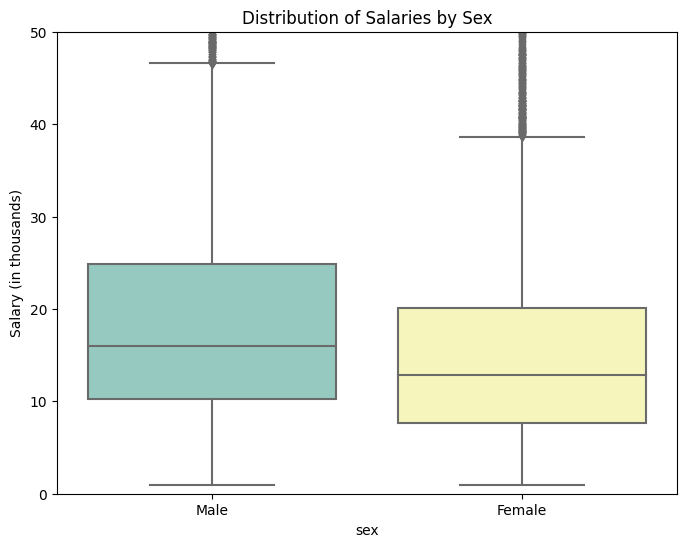

In [ ]:
#boxplot to visualize the distribution of salaries by gender('sex')
plt.figure(figsize=(8, 6))
sns.boxplot(x='sex', y='hrwage', data=df, palette="Set3")

plt.title('Distribution of Salaries by Sex')
plt.ylabel('Salary (in thousands)')

plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])

plt.ylim(0, 50)

plt.show()

In general, male earn higher hourly wage than female, with bigger average and range.

## Industry Based Wage

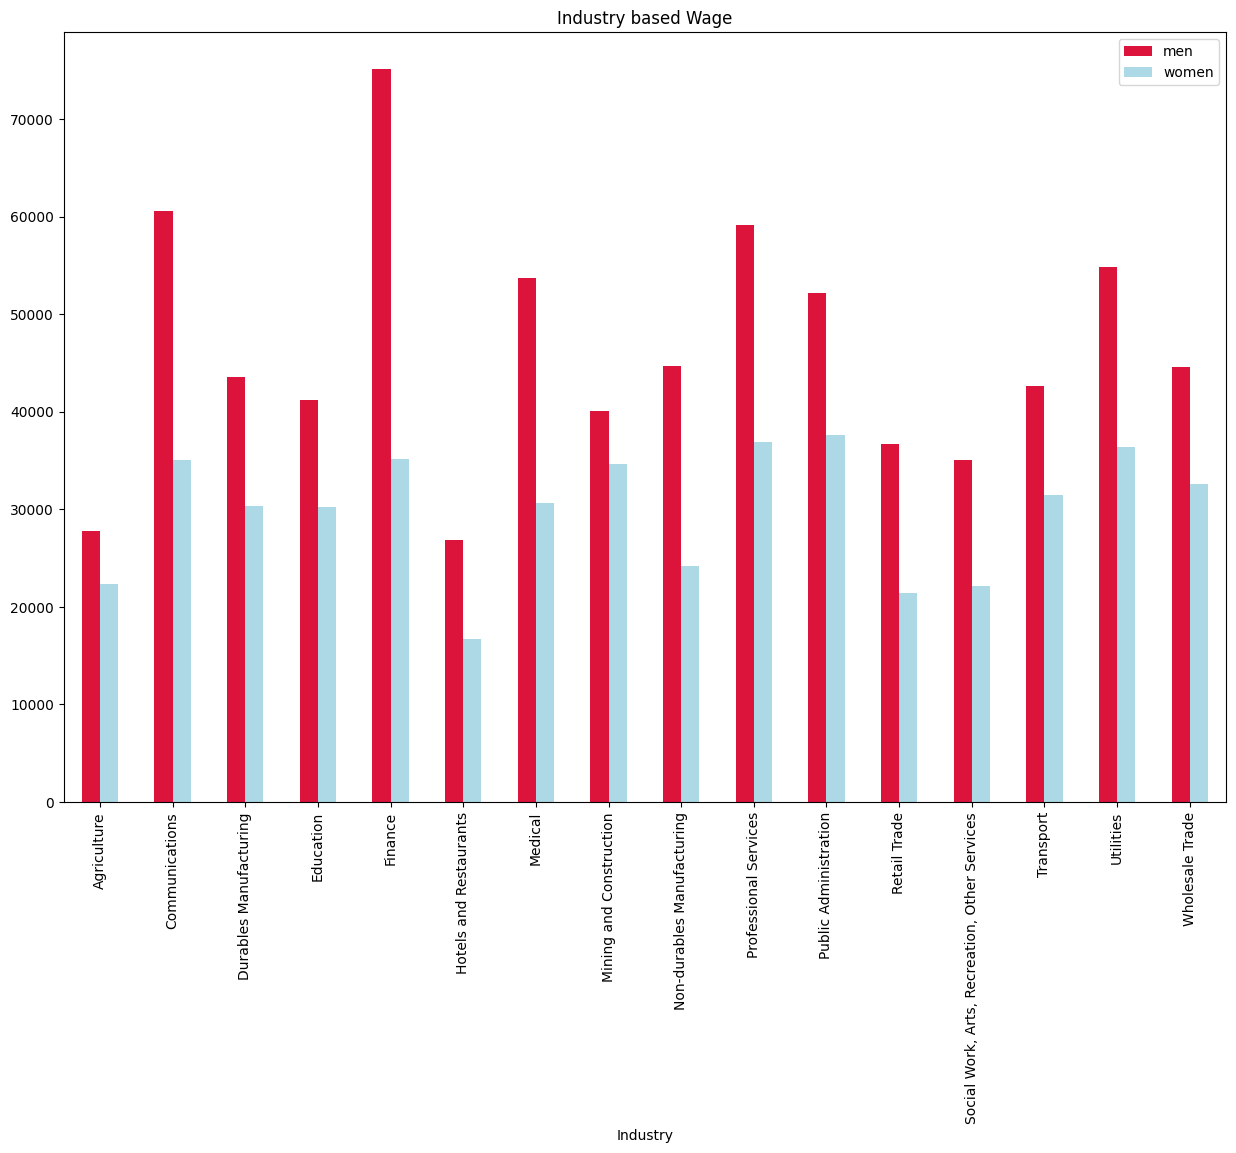

In [ ]:
#pivot table to calculate the mean total_income based on industry and gender
industry_based_wage = pd.pivot_table(df, values=['total_income'], index=['Industry'], columns=['sex'], aggfunc=np.mean)
#bar plot to visualize industry-based wage differences between men and women
ax = industry_based_wage.plot(kind='bar', figsize=(15, 10), rot=90, color=['crimson', 'lightblue'])
ax.legend(["men", "women"])
_ = ax.set_title("Industry based Wage")

In every industry, male earn higher income than female. The pay gap is most significant in finance, communications, medical, and non-durables manufacturing.

## Occupation Based Wage

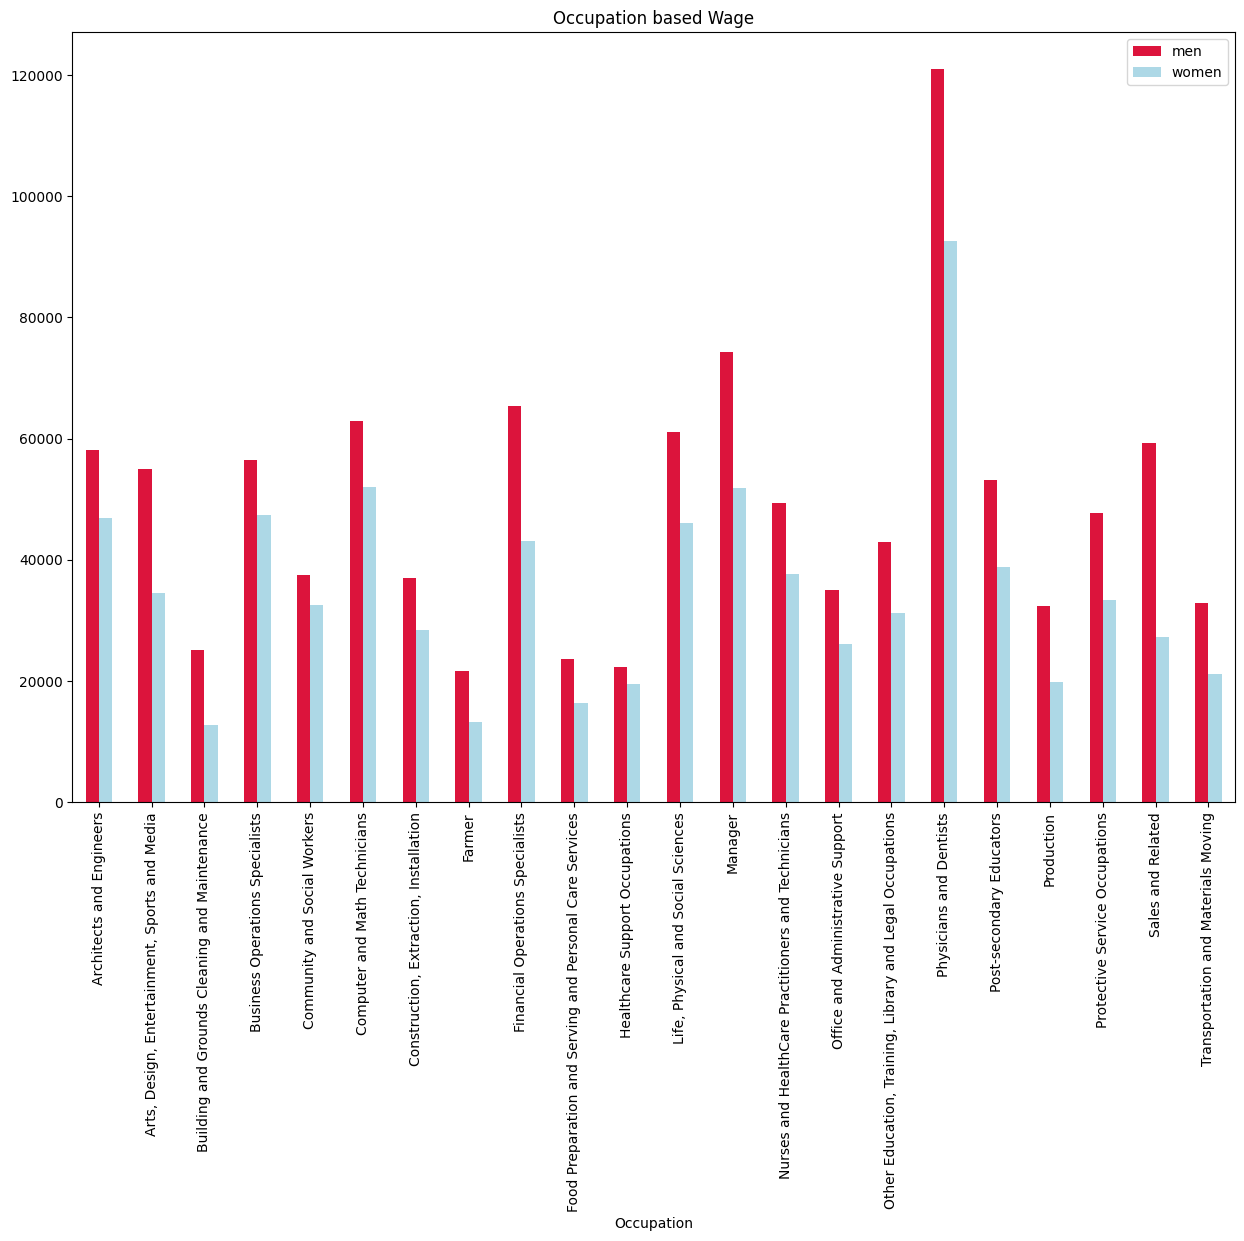

In [ ]:
#pivot table to calculate the mean total income based on occupation and gender
occupation_based_wage = pd.pivot_table(df, values=['total_income'], index=['Occupation'], columns=['sex'], aggfunc=np.mean)
#bar plot to visualize occupation-based wage differences between men and women
ax = occupation_based_wage.plot(kind='bar', figsize=(15, 10), rot=90, color=['crimson', 'lightblue'])
ax.legend(["men", "women"])
_ = ax.set_title("Occupation based Wage")

Here is bar plot comparing the income between male and felamoe in various occupations.

## Wage Over Time

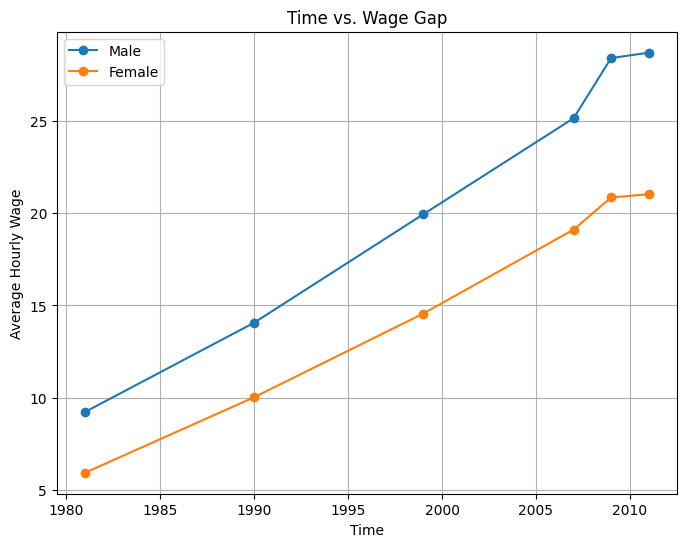

In [ ]:
#Group by 'wave' and 'sex' and calculate the mean hourly wage for each group
average_wages = df.groupby(['wave', 'sex'])['hrwage'].mean().unstack()

#line plot to visualize the average hourly wage over time for men and women
plt.figure(figsize=(8, 6))
average_wages.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Wage Over Time')
plt.xlabel('Time')
plt.ylabel('Average Hourly Wage')
plt.legend(['Male', 'Female'])
plt.grid(True)
plt.show()

The wage gap between the two genders have been quite consistent, but it is getting bigger gradually. There was more fluctuation near 2010, maybe things begun to change around then.

## Wage by Education Level & Gender

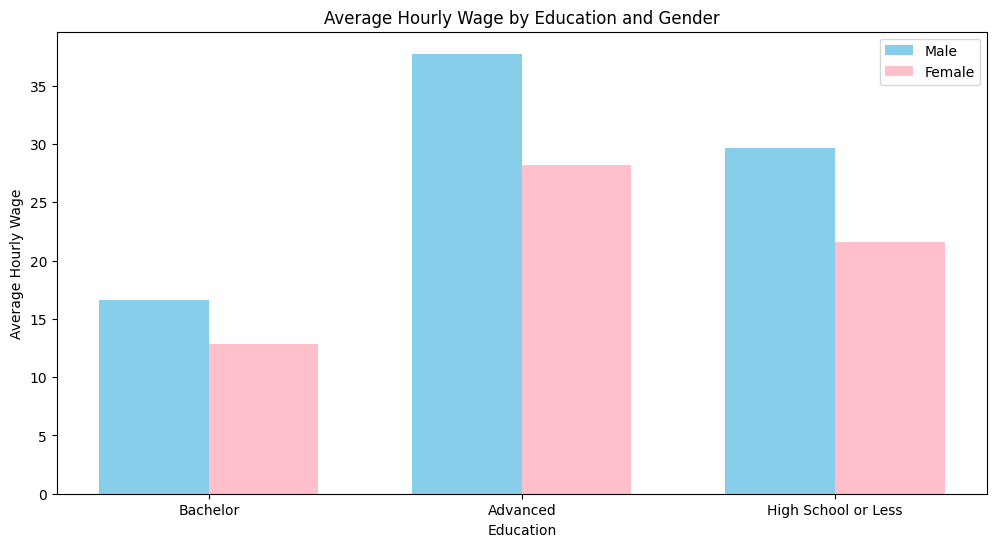

In [ ]:
#take relevant columns for analysis
education_wage = df[['ba', 'adv', 'LEHS', 'sex','hrwage']].copy()
#group data from columns indivadually
male = education_wage[education_wage['sex'] == 1]
female = education_wage[education_wage['sex'] == 2]

#Calculate male's average hourly wage by education level
male_avg_hrwage_by_education = male.groupby(['ba', 'adv', 'LEHS'])['hrwage'].mean().reset_index()
#Calculate female's average hourly wage by education level
female_avg_hrwage_by_education = female.groupby(['ba', 'adv', 'LEHS'])['hrwage'].mean().reset_index()

#merge
combined_data = male_avg_hrwage_by_education.merge(female_avg_hrwage_by_education, on=['ba', 'adv', 'LEHS'], suffixes=('_male', '_female'))

positions = range(len(combined_data))
bar_width = 0.35

#bar plot to visualize average hourly wage by education and gender
plt.figure(figsize=(12, 6))
plt.bar(positions, combined_data['hrwage_male'], bar_width, label='Male', color='skyblue')
plt.bar([pos + bar_width for pos in positions], combined_data['hrwage_female'], bar_width, label='Female', color='pink')

labels = ['Bachelor', 'Advanced', 'High School or Less']
plt.xticks([pos + bar_width / 2 for pos in positions], labels)

plt.title('Average Hourly Wage by Education and Gender')
plt.xlabel('Education')
plt.ylabel('Average Hourly Wage')
plt.legend()
plt.show()

It appears that it does not matter the education level, there is always a pay gap between male and female. There may be some underlying reasons for this gap, and maybe not, we will explore further using various modeling methods.

#V. Data Prep Pipeline

For the data preparation pipeline, we first selected the variables of interest for predictor and target, then proceeded with identifying the variables as categorical and linear, and created corresponding conversion pipelines.

In [ ]:
#drop columns
var = df.drop(columns=['hrwage', 'total_income', 'farminc', 'annlabinc', 'labincbus', 'realhrwage','intnum68','pernum68','intnum'], axis=1)
#display concise summary information about the modified DataFrame
var.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33398 entries, 0 to 33397
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wave            33398 non-null  int64  
 1   sex             33398 non-null  int64  
 2   region          33398 non-null  object 
 3   famwgt          33398 non-null  float64
 4   relhead         33398 non-null  object 
 5   age             33398 non-null  int64  
 6   sch             33373 non-null  float64
 7   annhrs          33398 non-null  int64  
 8   degree          33358 non-null  object 
 9   degree_updated  33358 non-null  object 
 10  sch_updated     33398 non-null  int64  
 11  annwks          33398 non-null  float64
 12  union_covered   33398 non-null  int64  
 13  usualhrwk       33303 non-null  float64
 14  yrsexp          33398 non-null  float64
 15  work_in_gov     33284 non-null  float64
 16  selfemp         33398 non-null  int64  
 17  smsa            33365 non-null 

In [ ]:
#assume feature variables X and target variables y
X = var
y = df['hrwage'].copy()
#split into train and test part
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=0)

In [ ]:
#set the display configuration to show pipeline diagrams
set_config(display='diagram')

#define categorical and numerical columns
cat_col = ['sex', 'region', 'relhead', 'degree','degree_updated', 'union_covered','work_in_gov', 'selfemp', 'smsa', 'full_time', 'ba', 'adv', 'LEHS', 'Race', 'Industry', 'Occupation']  # replace with your actual column names
num_col = num_col = [col for col in var.columns if col not in cat_col]

#numerical pipeline with imputation and standard scaling
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

#categorical pipeline with imputation and one-hot encoding
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder(drop='first'))
])

#column transformer to apply to numerical and categorical columns
prep_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_col),
    ('cat', cat_pipeline, cat_col)
])

prep_pipeline.fit(X_train)

prep_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['wave', 'famwgt', 'age', 'sch', 'annhrs',
                                  'sch_updated', 'annwks', 'usualhrwk',
                                  'yrsexp', 'perconexp', 'annhrs2',
                                  'inflate']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('cat_encoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['sex', 'region', 'relhead', 'degree',
                                  'degree_updated', 'union_covered',
                                  'work_in_gov', 'selfemp', 'smsa', 'full_time',
                                  'ba', 'adv', 'LEHS', 'Race', 'Industry',
                                  'Occupation'])])

#VI. Model Fitting


Optimal number of features: 67
Selected features: ['num__wave' 'num__famwgt' 'num__age' 'num__annhrs' 'num__sch_updated'
 'num__usualhrwk' 'num__yrsexp' 'num__perconexp' 'num__annhrs2'
 'num__inflate' 'cat__sex_2' 'cat__region_North-East' 'cat__region_South'
 'cat__region_Unknown' 'cat__region_West, Alaska and Hawaii'
 'cat__relhead_head' 'cat__relhead_legally married wife'
 'cat__degree_Bachelor’s w/o advanced degree'
 'cat__degree_No college degree'
 'cat__degree_updated_Bachelor’s w/o advanced degree'
 'cat__degree_updated_No college degree' 'cat__union_covered_1'
 'cat__work_in_gov_1.0' 'cat__smsa_1.0' 'cat__full_time_1' 'cat__ba_1'
 'cat__adv_1' 'cat__LEHS_1' 'cat__Race_2' 'cat__Race_3' 'cat__Race_4'
 'cat__Industry_Communications' 'cat__Industry_Durables Manufacturing'
 'cat__Industry_Education' 'cat__Industry_Finance'
 'cat__Industry_Hotels and Restaurants' 'cat__Industry_Medical'
 'cat__Industry_Mining and Construction'
 'cat__Industry_Non-durables Manufacturing'
 'cat__Industr

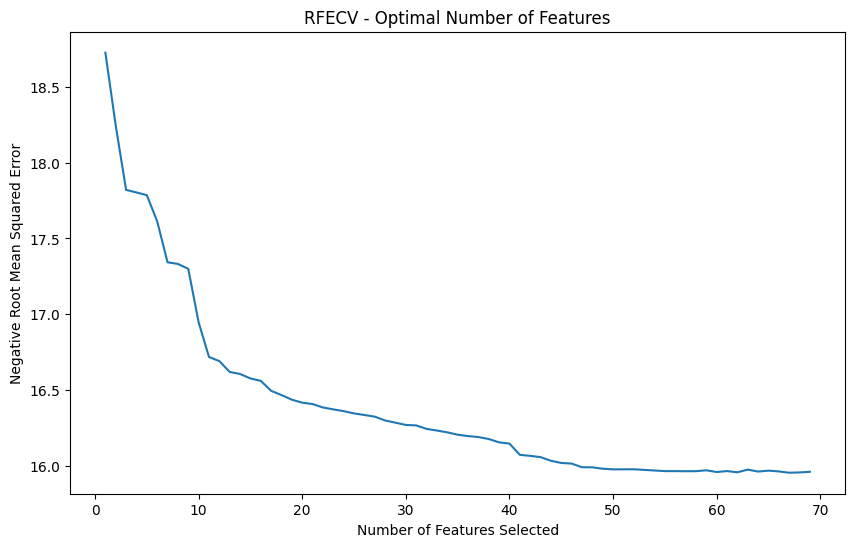

In [ ]:
#rfecv model using Linear Regression as the estimator and negative root mean squared error as the scoring metric
rfecv = RFECV(LinearRegression(), scoring='neg_root_mean_squared_error')

#pipeline that includes data preprocessing and RFECV feature selection
rfecv_pipe = Pipeline([
    ('prep', prep_pipeline),
    ('select', rfecv),
])

rfecv_pipe.fit(X_train, y_train)

#plot the number of features selected vs. negative root mean squared error
plt.figure(figsize=(10, 6))
plt.title("RFECV - Optimal Number of Features")
plt.xlabel("Number of Features Selected")
plt.ylabel("Negative Root Mean Squared Error")
mean_score = -rfecv.cv_results_['mean_test_score']
plt.plot(range(1, len(mean_score) + 1), mean_score)

#extract optimal number of features and corresponding negative RMSE
optimal_num_features = rfecv.n_features_
optimal_rmse = -rfecv.cv_results_['mean_test_score'][optimal_num_features - 1]
#print information
print(f"Optimal number of features: {optimal_num_features}")
print(f"Selected features: {rfecv_pipe['prep'].get_feature_names_out()[rfecv.support_]}")
print(f"RMSE at optimal number of features: {optimal_rmse}")

In [ ]:
#SelectKBest model using f_regression as the scoring function
kbest = SelectKBest(score_func=f_regression)

#pipeline that includes data preprocessing, SelectKBest feature selection, and Linear Regression modeling
k_best_pipe = Pipeline([
    ('prep', prep_pipeline),
    ('select', kbest),
    ('model', LinearRegression())
])

param_grid = {
    'select__k': range(1, X_train.shape[1] + 1)
}

#perform a grid search using cross-validation to find the optimal number of features
grid_search = GridSearchCV(k_best_pipe, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
display(cv_res.filter(regex = '(^param_|mean_test_score)', axis=1))

#print and extract the best model with selected features
best_model = grid_search.best_estimator_
print(f'The selected features are {best_model["prep"].get_feature_names_out()[best_model["select"].get_support()]}')

,param_select__k,mean_test_score
27,28,-16.309610
26,27,-16.314298
25,26,-16.330028
24,25,-16.340663
23,24,-16.344597
22,23,-16.347595
21,22,-16.360482
20,21,-16.375458
19,20,-16.395698
18,19,-16.402477


The selected features are ['num__wave' 'num__famwgt' 'num__age' 'num__sch' 'num__sch_updated'
 'num__yrsexp' 'num__perconexp' 'num__inflate' 'cat__sex_2'
 'cat__region_North-East' 'cat__region_South'
 'cat__degree_Bachelor’s w/o advanced degree'
 'cat__degree_No college degree'
 'cat__degree_updated_Bachelor’s w/o advanced degree'
 'cat__degree_updated_No college degree' 'cat__ba_1' 'cat__adv_1'
 'cat__LEHS_1' 'cat__Race_2' 'cat__Industry_Hotels and Restaurants'
 'cat__Occupation_Building and Grounds Cleaning and Maintenance'
 'cat__Occupation_Computer and Math Technicians'
 'cat__Occupation_Food Preparation and Serving and Personal Care Services'
 'cat__Occupation_Healthcare Support Occupations'
 'cat__Occupation_Manager'
 'cat__Occupation_Office and Administrative Support'
 'cat__Occupation_Physicians and Dentists' 'cat__Occupation_Production']


In [ ]:
#SelectFromModel model using Lasso regression as the base estimator
select_from_model = SelectFromModel(Lasso())

#pipeline that includes data preprocessing, SelectFromModel feature selection, and Lasso regression modeling
model_pipe = Pipeline([
    ('prep', prep_pipeline),
    ('select', select_from_model),
    ('model', Lasso())
])

#the parameter grid for SelectFromModel
param_grid = {
    'select__estimator__alpha': [10, 100, 1000],
    'select__threshold': ['mean', 'median']
}

#perform a grid search using cross-validation to find the optimal hyperparameters
grid_search = GridSearchCV(model_pipe, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

#display the grid search results sorted by mean test score
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
display(cv_res.filter(regex='(^param_|mean_test_score)', axis=1))

#extract the best model
best_model = grid_search.best_estimator_

selected_features = best_model['prep'].get_feature_names_out()[best_model['select'].get_support()]
print(f'The selected features are {selected_features}')

Best parameters: {'select__estimator__alpha': 10, 'select__threshold': 'mean'}


,param_select__estimator__alpha,param_select__threshold,mean_test_score
0,10,mean,-16.966943
1,10,median,-16.966943
2,100,mean,-16.966943
3,100,median,-16.966943
4,1000,mean,-16.966943
5,1000,median,-16.966943


The selected features are ['num__wave' 'num__famwgt' 'num__age' 'num__sch' 'num__annhrs'
 'num__sch_updated' 'num__annwks' 'num__usualhrwk' 'num__yrsexp'
 'num__perconexp' 'num__annhrs2' 'num__inflate' 'cat__sex_2'
 'cat__region_North-East' 'cat__region_South' 'cat__region_Unknown'
 'cat__region_West, Alaska and Hawaii' 'cat__relhead_head'
 'cat__relhead_legally married wife'
 'cat__degree_Bachelor’s w/o advanced degree'
 'cat__degree_No college degree'
 'cat__degree_updated_Bachelor’s w/o advanced degree'
 'cat__degree_updated_No college degree' 'cat__union_covered_1'
 'cat__work_in_gov_1.0' 'cat__smsa_1.0' 'cat__full_time_1' 'cat__ba_1'
 'cat__adv_1' 'cat__LEHS_1' 'cat__Race_2' 'cat__Race_3' 'cat__Race_4'
 'cat__Industry_Communications' 'cat__Industry_Durables Manufacturing'
 'cat__Industry_Education' 'cat__Industry_Finance'
 'cat__Industry_Hotels and Restaurants' 'cat__Industry_Medical'
 'cat__Industry_Mining and Construction'
 'cat__Industry_Non-durables Manufacturing'
 'cat__Indus

We have tested all three feature selection methods above, in three separate copies of our notebook, and the recursive feature elimination with cross-validation generated the best result.

##OLS Linear regression

In [ ]:
#linear regression pipeline using RFECV feature selection
lin_reg_pipeline = make_pipeline(rfecv_pipe, LinearRegression())

#fit on train data
lin_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('prep',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['wave',
                                                                    'famwgt',
                                                                    'age',
                                                                    'sch',
                                                                    'annhrs',
                                                                    'sch_updated',
                                                                    'annwks',
                                                                    'usualhrwk',
                                                                    'yrsexp',
                                                                    'perconexp',
                                                                    'annhrs2',
                                                                    'inflate']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('cat_encoder',
                                                                                    OneHotEncoder(drop='first'))]),
                                                                   ['sex',
                                                                    'region',
                                                                    'relhead',
                                                                    'degree',
                                                                    'degree_updated',
                                                                    'union_covered',
                                                                    'work_in_gov',
                                                                    'selfemp',
                                                                    'smsa',
                                                                    'full_time',
                                                                    'ba', 'adv',
                                                                    'LEHS',
                                                                    'Race',
                                                                    'Industry',
                                                                    'Occupation'])])),
                                 ('select',
                                  RFECV(estimator=LinearRegression(),
                                        scoring='neg_root_mean_squared_error'))])),
                ('linearregression', LinearRegression())])

In [ ]:
#extract linear_reg_model from pipline
linear_model = lin_reg_pipeline.named_steps['linearregression']

In [ ]:
#predictions on the test set using the linear regression pipeline
y_pred = lin_reg_pipeline.predict(X_test)
#regression performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("R-squared:", r2)

#cross-validation and calculate the mean RMSE
lin_cv_rmses = -cross_val_score(lin_reg_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
print('Cross-validation RMSE: {:.2f}'.format(lin_cv_rmses.mean()))


MSE: 324.03281601508075
RMSE: 18.000911532894126
R-squared: 0.2624181568311722
Cross-validation RMSE: 15.96


## Random Forest Regressor



In [ ]:
#random forest regression pipeline using RFECV feature selection
rfr_pipeline = make_pipeline(rfecv_pipe, RandomForestRegressor(random_state=0))
rfr_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('prep',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['wave',
                                                                    'famwgt',
                                                                    'age',
                                                                    'sch',
                                                                    'annhrs',
                                                                    'sch_updated',
                                                                    'annwks',
                                                                    'usualhrwk',
                                                                    'yrsexp',
                                                                    'perconexp',
                                                                    'annhrs2',
                                                                    'inflate']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_freque...
                                                                                   ('cat_encoder',
                                                                                    OneHotEncoder(drop='first'))]),
                                                                   ['sex',
                                                                    'region',
                                                                    'relhead',
                                                                    'degree',
                                                                    'degree_updated',
                                                                    'union_covered',
                                                                    'work_in_gov',
                                                                    'selfemp',
                                                                    'smsa',
                                                                    'full_time',
                                                                    'ba', 'adv',
                                                                    'LEHS',
                                                                    'Race',
                                                                    'Industry',
                                                                    'Occupation'])])),
                                 ('select',
                                  RFECV(estimator=LinearRegression(),
                                        scoring='neg_root_mean_squared_error'))])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=0))])

In [ ]:
#fit random forest reg pipline
rfr_pipeline.fit(X_train, y_train)

#predictions on the test with rfr
y_pred = rfr_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("R-squared:", r2)

MSE: 262.47087643858805
RMSE: 16.20095294847152
R-squared: 0.4025489294494746


## Supprt Vector Regression

In [ ]:
#support vector regression pipeline using RFECV feature selection
svr_pipeline = make_pipeline(rfecv_pipe, SVR())
#fit the svm regression pipeline
svr_pipeline.fit(X_train, y_train)

#perform cross-validation and calculate the mean RMSE for SVM
svr_cv_scores = cross_val_score(svm_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print('SVM CV RMSE:', np.sqrt(-np.mean(svr_cv_scores)))

y_pred = svr_pipeline.predict(X_test)

#regression performance metrics for the test
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test set RMSE:', test_rmse)

mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {mae:.2f}')

r2 = r2_score(y_test, y_pred)
print(f'Test R-squared: {r2:.2f}')

SVM CV RMSE: 16.096490372907994
Test set RMSE: 18.09349296251554
Test MAE: 6.18
Test R-squared: 0.25


## Gradiant Boosting Machines

In [ ]:
#gradient boosting regression pipeline using rfecv feature selection
gbm_pipeline = make_pipeline(rfecv_pipe, GradientBoostingRegressor(random_state=0))
#fit gbm
gbm_pipeline.fit(X_train, y_train)

#cross-validation and calculate the mean RMSE for GBM
gbm_cv_scores = cross_val_score(gbm_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print('GBM CV RMSE:', np.sqrt(-np.mean(gbm_cv_scores)))

#predictions on the test gbm
y_pred = gbm_pipeline.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test set RMSE:', test_rmse)

#R-squared
r_squared_gb = gbm_pipeline.score(X_test, y_test)
print("Gradient Boosting R-squared:", r_squared_gb)

GBM CV RMSE: 15.69207290321551
Test set RMSE: 17.525832529398503
Gradient Boosting R-squared: 0.3008368392373785


## Neural Network

In [ ]:
#MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42)

#pipeline for MLPRegressor with rfecv feature selection
model = Pipeline(steps=[
    ('prep', rfecv_pipe['prep']),
    ('select', rfecv_pipe['select']),
    ('mlp', mlp)
])

#fit
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_square = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r_square)

Mean Squared Error: 305.19223422921385
Root Mean Squared Error: 17.469751979613616
R-squared: 0.30530415588179305


## KNN

In [ ]:
#k-nearest neighbors regression pipeline using rfecv feature selection
knn_pipeline = make_pipeline(rfecv_pipe, KNeighborsRegressor())
knn_pipeline.fit(X_train, y_train)

knn_cv_scores = cross_val_score(knn_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print('KNN CV RMSE:', np.sqrt(-np.mean(knn_cv_scores)))

#predictions on the test
y_pred = knn_pipeline.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test set RMSE:', test_rmse)

#R-squared
r_squared_knn = knn_pipeline.score(X_test, y_test)
print("KNN R-squared:", r_squared_knn)

KNN CV RMSE: 16.27486072891733
Test set RMSE: 17.486259425012882
KNN R-squared: 0.3039906773947373


## Lasso/Ridge

In [ ]:
#Lasso regression pipeline using rfecv feature selection
lasso_pipeline = make_pipeline(rfecv_pipe, Lasso(alpha=1.0))

lasso_pipeline.fit(X_train, y_train)

#cross-validation and the mean RMSE
lasso_cv_rmses = -cross_val_score(lasso_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
print('Lasso RMSE:', lasso_cv_rmses.mean())

#R-squared
r_squared_lasso = lasso_pipeline.score(X_test, y_test)
print("Lasso Regression R-squared:", r_squared_lasso)

Lasso RMSE: 16.995867508347054
Lasso Regression R-squared: 0.17305274106430302


In [ ]:
#ridge regression pipeline using rfecv feature selection
ridge_pipeline = make_pipeline(rfecv_pipe, Ridge(alpha=1.0))
ridge_pipeline.fit(X_train, y_train)

#cross-validation and the mean RMSE
ridge_cv_rmses = -cross_val_score(ridge_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
print('Ridge RMSE:', ridge_cv_rmses.mean())

#R-squared
r_squared_ridge = ridge_pipeline.score(X_test, y_test)
print("Ridge Regression R-squared:", r_squared_ridge)


Ridge RMSE: 15.954080802002746
Ridge Regression R-squared: 0.2623348998286755


#VII. Model Tuning

Based on the above results, the "Random Forest Regressor" model is selected to be further fine-tuned. Because of the size of our data, we decided to proceed with a random search to fine-tune the data.

In [ ]:
#parameter distributions for RandomizedSearchCV
param_distributions = {
    'randomforestregressor__n_estimators': sp_randint(100, 200),
    'randomforestregressor__max_depth': [None] + list(range(10, 15)),
}

random_search = RandomizedSearchCV(rfr_pipeline, param_distributions=param_distributions,
                                   n_iter=10, cv=2, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

#the best model from the RandomizedSearchCV results
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", random_search.best_params_)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-squared:", r2)


Best Parameters: {'randomforestregressor__max_depth': 13, 'randomforestregressor__n_estimators': 199}
MSE: 260.8417836984496
RMSE: 16.15059700749324
R-squared: 0.4062571625869119


#VIII. Stacking

We then stacked our models to see if a stacked regressor would produce better results. Based on previous results, we selected the random forest regressor, the support vector regressor, and the gradient boosting regressor for stacking.

In [ ]:
#split
X = var
y = df['hrwage'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=0)

In [ ]:
#categorical and numerical columns for preprocessing
cat_col = ['sex', 'region', 'relhead', 'degree','degree_updated', 'union_covered','work_in_gov', 'selfemp', 'smsa', 'full_time', 'ba', 'adv', 'LEHS', 'Race', 'Industry', 'Occupation']  # replace with your actual column names
num_col = num_col = [col for col in var.columns if col not in cat_col]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder(drop='first'))
])

prep_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_col),
    ('cat', cat_pipeline, cat_col)
    ])

#individual pipelines for Random Forest, SVR, and Gradient Boosting models
pipeline_rfr = Pipeline(steps=[('preprocessor', prep_pipeline), ('randomforestregressor', RandomForestRegressor())])
pipeline_svr = Pipeline(steps=[('preprocessor', prep_pipeline), ('svr', SVR())])
pipeline_gbm = Pipeline(steps=[('preprocessor', prep_pipeline), ('gradientboostingregressor', GradientBoostingRegressor())])

#StackingRegressor with Random Forest, SVR, and Gradient Boosting as base estimators, and Linear Regression
stacked_regressor = StackingRegressor(
    estimators=[
        ('rf', pipeline_rfr),
        ('svm', pipeline_svr),
        ('gbm', pipeline_gbm),
    ],
    final_estimator=LinearRegression()
)

stacked_regressor.fit(X_train, y_train)

#predictions on the test with stackingRegressor
y_pred = stacked_regressor.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)

Mean Absolute Error: 6.26591164801822
Mean Squared Error: 267.08542318310975
Root Mean Squared Error: 16.342748336283886
R² Score: 0.39204503686516723


Comparing the results of the stacked model with the previous random forest regressor, we can see that the results are very similar, with slight differences in which the random forest regressor has slightly lower MSE, RMSE, and a higher R^2. Therefore, the random forest regressor has performed better throughout all observed models.

# IX. Predictions

In [ ]:
#Sample 5 instances from the test and get indices
sampled_X_test = X_test.sample(5, random_state=42)
sampled_indices = sampled_X_test.index

#predictions on the sampled test instances using the best model
predicted_wages = best_model.predict(sampled_X_test)

actual_wages = y_test.loc[sampled_indices]

#comparison between actual and predicted wages
comparison_df = pd.DataFrame({
    'Actual Wage': actual_wages,
    'Predicted Wage': predicted_wages
})

#calculate the average of actual wage and predicted wage
average_actual_wage = actual_wages.mean()
average_predicted_wage = predicted_wages.mean()

comparison_df.loc['Average'] = [average_actual_wage, average_predicted_wage]

print(comparison_df)

#mean absolute error
mae = mean_absolute_error(actual_wages, predicted_wages)

print(f"Mean Absolute Error for the sample: {mae}")

         Actual Wage  Predicted Wage
29671      34.666668       16.478306
20884       7.004310       13.868597
13299      13.461538       19.888598
20651       9.236453       13.709111
29309      17.000000       14.016823
Average    16.273794       15.592287
Mean Absolute Error for the sample: 7.7871085488347855


First, we randomly selected five people in our dataset to evaluate the performance of our model. The difference between predicted and actual hourly wage for each individual varies quite a lot. However, the difference between the average hourly pay predicted and actual was very close. This suggests that our model works best when predicting the average hourly wage of groups.

In [ ]:
#group individually
X_test_male = X_test[X_test['sex'] == 1]
X_test_female = X_test[X_test['sex'] == 2]

#predictions on instances for males and females
predicted_wages_male = model.predict(X_test_male)
predicted_wages_female = model.predict(X_test_female)

#average predicted wage for males and females
average_wage_male = np.mean(predicted_wages_male)
average_wage_female = np.mean(predicted_wages_female)

#predicted pay gap
pay_gap = average_wage_male - average_wage_female

print(f"Average Predicted Wage for Males: {average_wage_male}")
print(f"Average Predicted Wage for Females: {average_wage_female}")
print(f"Predicted Pay Gap: {pay_gap}")

Average Predicted Wage for Males: 20.630971153837237
Average Predicted Wage for Females: 15.319697911986514
Predicted Pay Gap: 5.3112732418507225


Now, let’s look at the wage between males and females; the predicted pay gap is around 5.31.

In [ ]:
#pay gap over time by grouping
pay_gap_over_time = X_test.groupby('wave').apply(
    lambda df: model.predict(df[df['sex'] == 1]).mean() - model.predict(df[df['sex'] == 2]).mean())
print("Pay Gap Over Time:\n", pay_gap_over_time)

Pay Gap Over Time:
 wave
1981    3.437603
1990    4.500389
1999    4.649528
2007    7.362488
2009    6.955293
2011    8.149521
dtype: float64


The pay gap over time appears to have been increasing quite significantly. Note that the years were very different. Hence, we must factor in the inflation to compare the hourly wage.

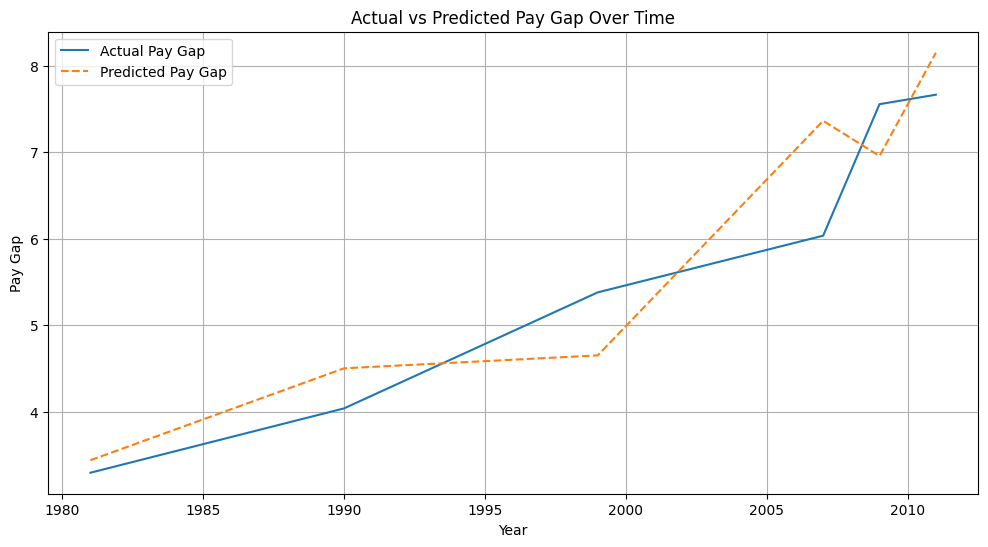

In [ ]:
#the actual pay gap over time by grouping
actual_pay_gap_over_time = df.groupby('wave').apply(
    lambda x: x[x['sex'] == 1]['hrwage'].mean() - x[x['sex'] == 2]['hrwage'].mean())

#combining actual and predicted pay gaps over time
combined_pay_gap = pd.DataFrame({
    'Year': actual_pay_gap_over_time.index,
    'Actual Pay Gap': actual_pay_gap_over_time.values,
    'Predicted Pay Gap': pay_gap_over_time.values
})

#graph of actual and predicted pay gaps over time
plt.figure(figsize=(12, 6))
plt.plot(combined_pay_gap['Year'], combined_pay_gap['Actual Pay Gap'], label='Actual Pay Gap')
plt.plot(combined_pay_gap['Year'], combined_pay_gap['Predicted Pay Gap'], label='Predicted Pay Gap', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Pay Gap')
plt.title('Actual vs Predicted Pay Gap Over Time')
plt.legend()
plt.grid(True)
plt.show()

The graph shows the difference between the predicted and actual pay gap; the trends and directions are the same. It suggests that the model captures the overall trend in data quite well and can forecast the pay gap's path over time. The model lags behind the actual movement and had difficulty grasping the pay gap around 2010.

In [ ]:
#average inflation rate over time by grouping
inflation=X_test.groupby('wave')['inflate'].mean()
#inflation-adjusted pay gap over time
pay_gap_over_time = X_test.groupby('wave').apply(
    lambda df: (model.predict(df[df['sex'] == 1]).mean() -
                model.predict(df[df['sex'] == 2]).mean()) * inflation[df.name]
)

print("Inflation-Adjusted Pay Gap Over Time:\n", pay_gap_over_time)

Inflation-Adjusted Pay Gap Over Time:
 wave
1981    7.946109
1990    7.077390
1999    5.912917
2007    7.900793
2009    7.065881
2011    8.149521
dtype: float64


After factoring in the inflation, the pay gap was very close to each other; it has fluctuated. The gap closed to 6 around 1999, but it got even more significant than it was in 2011.

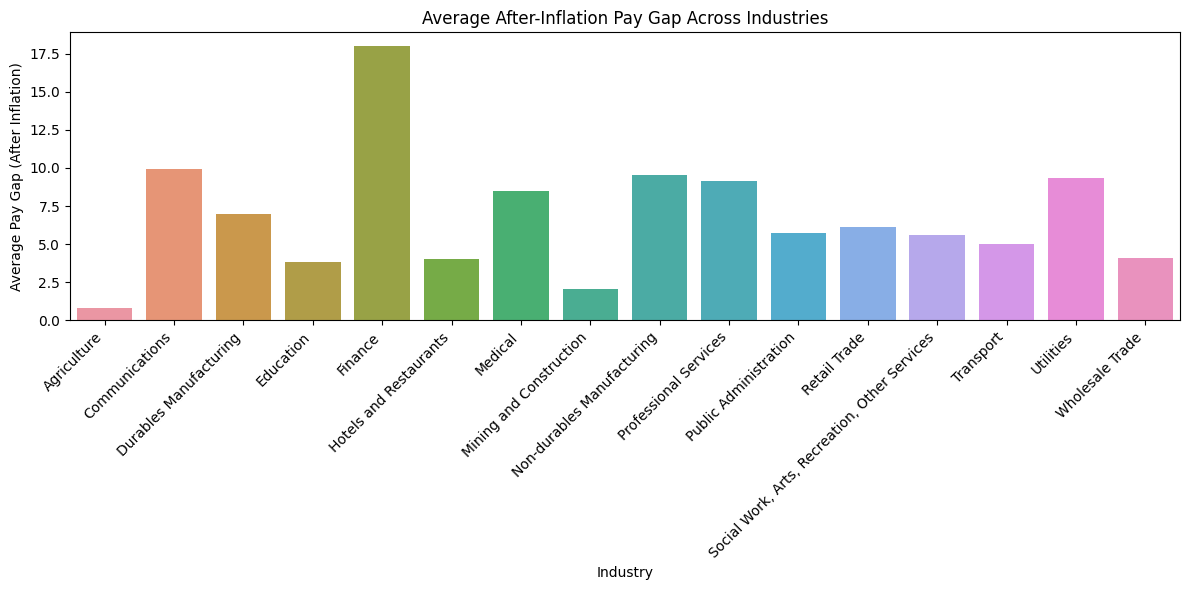

In [ ]:
#create a new column with hrwage*inflate, hence there is adjusted_wage
df['adjusted_wage'] = df['hrwage'] * df['inflate']

#average wage for each gender in each industry
industry_gender_avg_wage = df.groupby(['Industry', 'sex'])['adjusted_wage'].mean().unstack()

#pay gap for each industry by subtracting female average wage from male average wage
industry_pay_gap = industry_gender_avg_wage[1] - industry_gender_avg_wage[2]

#average after-inflation pay gap across industries
plt.figure(figsize=(12, 6))
sns.barplot(x=industry_pay_gap.index, y=industry_pay_gap.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Industry')
plt.ylabel('Average Pay Gap (After Inflation)')
plt.title('Average After-Inflation Pay Gap Across Industries')
plt.tight_layout()
plt.show()

Last but not least, this graph portrays the predicted gender pay gap in different industries, which is not too different from the chart we had in EDA. The finance industry has the highest gap, while the agriculture industry treats males and females more equally.

# X. Challenges

One of the most significant challenges is that the dataset does not have many numerical features, and there were too many distinct categories in some of our categorical features, such as industry and occupation. It would take more work for the model to make accurate predictions.

Furthermore, salaries in different industries and occupations can vary significantly; it is harder to observe the gender pay gap when all sectors and professions are accounted for together. The result could be more accurate and reliable if the dataset is refined to only one industry.

The data needs to be updated. The latest entry for our data is 2011. Many things have changed, and people have become much more aware of the gender pay gap. Over the past ten years, it is very possible that the gap has been reduced.

Last but not least, our dataset was huge; it had nearly 300 columns, and it was very time-consuming to prepare it for our EDA and modelling. Since the dataset was huge, many of the acceptable tuning methods could not run, and it took a very long time to run everything every time we reconnected.

# XI. Conclusion

In our comprehensive analysis of income disparities across males and females over two decades using the Panel Study of Income Dynamics dataset. We delve into various factors, including age, education, occupation, years of experience, geographic location, and much more, to uncover the underlying cause of these disparities.

Our data exploratory phase revealed gender pay gaps between the two genders despite variations in many factors. The gap has increased over the years before accounting for inflation.

Utilizing a Recursive Feature Elimination with Cross-Validation (RFECV) model, we selected optimal features for prediction with Linear Regression as the estimator. Further, we incorporate various advanced predictive modelling techniques, including linear regression, random forest regressor, and neural networks. Our model captured the overall trends in the data to forecast individual income. If we had access to more recent data, our model would be much more accurate and could be used to evaluate more recent gender pay gaps.

The gender pay gap has been relatively consistent when we factor in the inflation. While educational and professional advancements have been made, the gap persists. Addressing this disparity requires further investigation into other factors and efforts of society.

Lastly, some additional appliation of our model would be identifying factors that caused gender pay gap, to policy makers, HR departments, and address those issues direclty. Our model also provides job recommendations, such as which industry and occupation to work in, to obtain income equality, before this gap is eliminated. On top of that, our model theoretically would be able to predict the average income and income gap if we encounter datasets that do not contian salary related infromation.


# XII. References

- Data source: https://www.kaggle.com/fedesoriano/gender-pay-gap-dataset
- 810 Lab Notebooks
- We have used Chat GPT to remove typos in our analysis, and remove dublicated package/library imported when we were combining our works.